In [1]:
import os
import math
import pandas

import seaborn as sns
import matplotlib.pyplot as plt

from src.data.annotations import load_dataset_annotations, load_noise_classes
from src.data.annotations import make_continious_labels, single_track_labels
from src.data.annotations import make_multitrack_labels
from src.visualization.events import legend_without_duplicate_labels
from src.features.soundlevel import compute_background
from src.utils.fileutils import get_project_root

In [2]:
annotations = load_dataset_annotations()

m = load_noise_classes()
m.noise.value_counts()

aa = annotations.copy()
aa['noise_class'] = aa.annotation.map(m.noise.to_dict())
all_classes = sorted(aa.noise_class.unique())
multi_track = aa.groupby(['dataset', 'clip']).apply(make_multitrack_labels, classes=all_classes)
# multi_track

# limit to just the MAESTRO dataset for this analysis
multi_track = multi_track.loc[['maestro']]

single_track = multi_track.groupby(['dataset', 'clip'], group_keys=False).apply(single_track_labels)
#single_track

skipping archive
skipping MAESTRO_annotation_notes.md
skipping archive
skipping b093_annotations_BD.txt.bak
skipping TUT_annotation_notes.md
skipping File-1.wav
skipping File-2.wav
skipping File-3.wav


In [3]:
def import_soundlevels(speed: str = 'LAF'):
    return pandas.read_parquet(os.path.join(get_project_root(), f'data/processed/soundlevels/{speed}.parquet'))

In [4]:
def upsample_levels(df: pandas.DataFrame, freq='100ms'):
    out = df.copy()
    out = out.reset_index(allow_duplicates=True).set_index('time')
    out = out[['level', 'background', 'delta']]
    
    # isinstance(out.index, pandas.DatetimeIndex)

    return out.resample(freq).ffill()

In [5]:
def downsample_levels(df: pandas.DataFrame, freq='100ms'):
    out = df.copy()
    out = out.reset_index(allow_duplicates=True).set_index('time')
    out = out[['level', 'background', 'delta']]
    
    # isinstance(out.index, pandas.DatetimeIndex)

    return out.resample(freq).mean()

In [6]:
def map_levels_to_labels(single: pandas.DataFrame, speed='LAF'):
    '''
    Imports the saved soundlevels for LAF/LAS, computes background levels, resamples levels
    to match the Timedelta of the single track labels, then renames/relabels instances of "background"
    which are actually sound events.
    '''
    
    soundlevels = import_soundlevels(speed=speed)
    
    # compute background levels and delta
    sb = soundlevels.groupby(['dataset', 'clip'])['level'].apply(compute_background, window=30.0)
    
    # apply resampling then recompute delta
    up_down = {'LAF': downsample_levels, 'LAS': upsample_levels}
        
    sb = sb.groupby(['dataset', 'clip'])[['level', 'background', 'delta']].apply(up_down[speed])
    
    
    
    sb['delta'] = sb['level'] - sb['background']
    
    # merge the resampled levels with the labels
    df = pandas.DataFrame(single).merge(sb, how='left', left_index=True, right_index=True)
    
    print(f'{speed} Shape:', df.shape)

    # mark timestamps where delta exceeds +5db (sound events)
    df['event'] = df['delta'] >= 5
    
    # print(df['event'].value_counts())
    
    
    # print(df[0].value_counts())
    
    # if a timestamp is NOT an event, label it as background
    df[0] = df[0].where(df['event'], other='background')
    
    # print(df[0].value_counts())

    # if a timestamp is labelled as "background", but also a sound event - re-label to "unknown"
    df['unknown'] = (df[0] == 'background') & (df['event'] == True)
    df[0] = df[0].mask(df['unknown'], other='unknown')
    
    # print(df[0].value_counts())

    df = df.rename(columns={0: 'label'})
    
    df = df[['label', 'level', 'background', 'delta']]

    return df
    

### Import soundlevels and map to labels

In [7]:

LAF = map_levels_to_labels(single = single_track, speed='LAF')
# Restrict analysis to only the MAESTRO dataset
LAF = LAF.loc[['maestro']]

LAS = map_levels_to_labels(single = single_track, speed='LAS')
# Restrict analysis to only the MAESTRO dataset
LAS = LAS.loc[['maestro']]

LAF Shape: (23941, 4)
LAS Shape: (23941, 4)


## What is the overall proportion of Sound Event Activations per LAF/LAS configuration?

In [8]:
def prop_se_to_background(df):
    label_pct = df['label'].value_counts(normalize=True).mul(100)
    background = round(label_pct['background'], 2)
    return (round(100-background, 2), background)

In [9]:
LAF_sed_to_background = prop_se_to_background(LAF)
LAS_sed_to_background = prop_se_to_background(LAS)

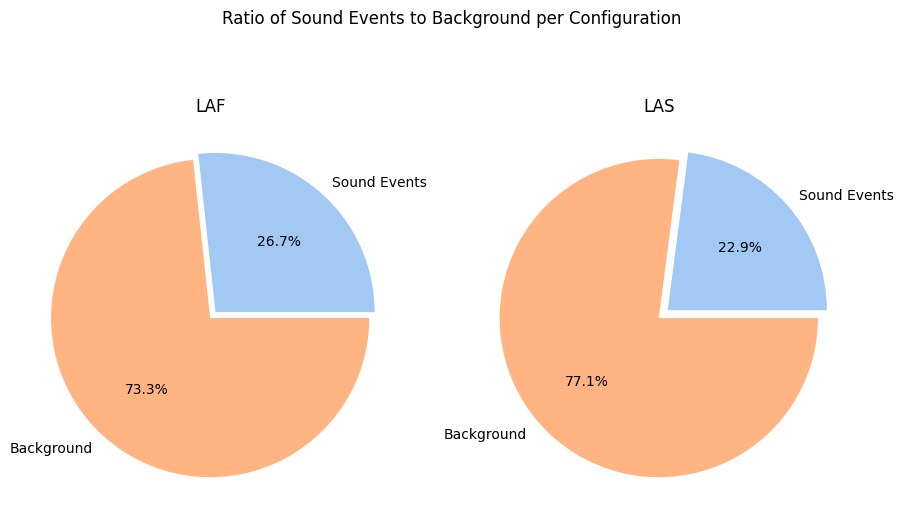

In [10]:
colors = sns.color_palette('pastel')[0:2]
fig = plt.figure(figsize=(9,6), constrained_layout=True)
#1 row 2 columns
fig.suptitle('Ratio of Sound Events to Background per Configuration')
#first row, first column
ax1 = plt.subplot2grid((1,2),(0,1))
explode = [0.075, 0]
plt.pie(LAS_sed_to_background, labels=['Sound Events', 'Background'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAS')

#first row sec column
ax1 = plt.subplot2grid((1,2),(0,0))
explode = [0.05, 0]
plt.pie(LAF_sed_to_background, labels=['Sound Events', 'Background'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAF')

plt.show()

### How does the proportion of Sound Events to Background vary between clips?

In [11]:
# for each dataset, groupby "clip", then generate se:background distruibutions
def clipwise_se_dist(df, speed: str = 'LAF'):
    
    df = df.groupby(['dataset', 'clip'])[['label']].apply(prop_se_to_background)
    df = df.reset_index().drop(columns=['dataset']).set_index('clip')

    df = pandas.DataFrame(df[0].tolist(), index=df.index).reset_index().rename(columns={0: 'events'})
    df = df[['clip', 'events']]
    df['speed'] = speed
    return df

In [12]:
# summarise at the clip level then concat
ldf = clipwise_se_dist(LAF, speed='LAF')
rdf = clipwise_se_dist(LAS, speed='LAS')

# concat the df's
df = pandas.concat([ldf, rdf])
df = df.sort_values(by='clip')

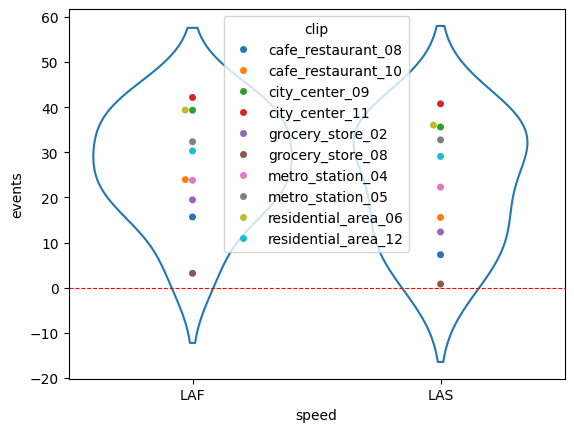

In [13]:
sns.violinplot(data=df, x='speed',  y='events', inner=None, fill=False)
sns.swarmplot(data=df, x='speed', y='events', hue='clip')
plt.axhline(y=0, color='red', ls='--', linewidth=0.8)



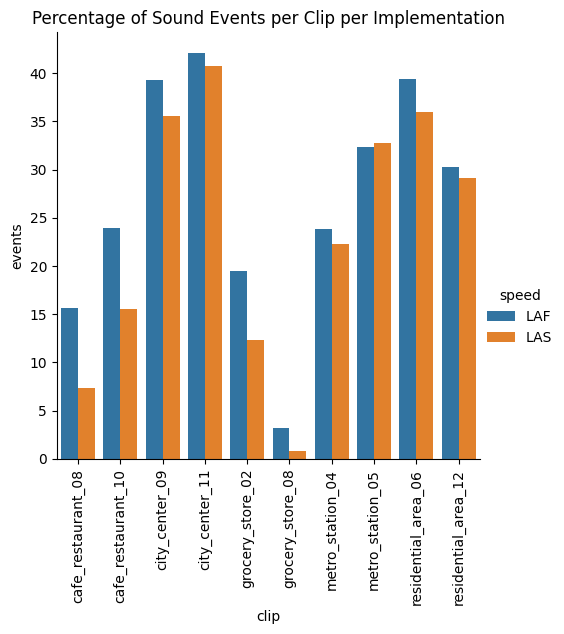

In [14]:
sns.catplot(data=df, x='clip',  y='events', hue='speed', kind='bar')
plt.title('Percentage of Sound Events per Clip per Implementation')
plt.xticks(rotation=90)
plt.show()

### What is the relationship between the proportion of sound events detected by each implementation?

In [15]:
# merge the left and right frames, generate a new feature which divides LAS by LAF
df = ldf.merge(rdf, how='outer', on='clip', suffixes=('_LAF', '_LAS'))
df['LAS_over_LAF'] = df['events_LAS'] / df['events_LAF']
df = df[['clip', 'LAS_over_LAF']]
df

,clip,LAS_over_LAF
0,cafe_restaurant_08,0.467474
1,cafe_restaurant_10,0.650250
2,city_center_09,0.905876
3,city_center_11,0.966777
4,grocery_store_02,0.634497
5,grocery_store_08,0.258567
6,metro_station_04,0.936948
7,metro_station_05,1.012678
8,residential_area_06,0.915375
9,residential_area_12,0.960066


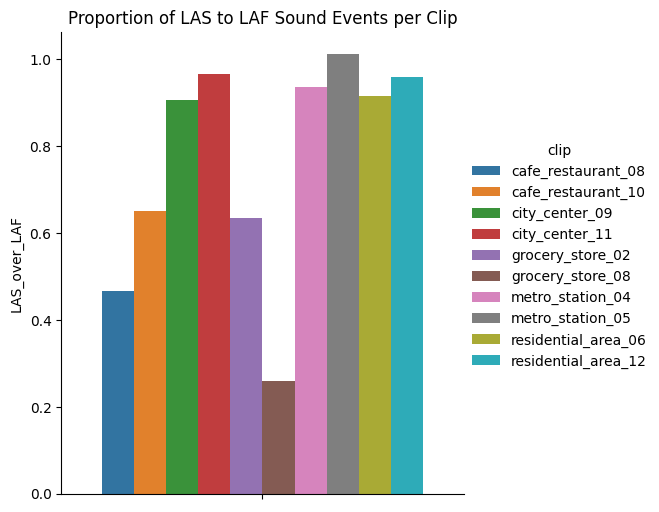

In [16]:
sns.catplot(data=df, y='LAS_over_LAF', hue='clip', kind='bar')
plt.title('Proportion of LAS to LAF Sound Events per Clip')
plt.show()

### The above chart does show some kind of relationship between LAS and LAF detections...

Indoor settings ("cafe_resaraunt" and "grocery_store") tend to have a weaker relationship between LAS and LAF activations. However, a third indoor setting "metro_station" tends to have more similar characteristics of the remaining "outdoor" scenes.

This may not be strictly to do with the setting being indoors or outdoors, and might be more to do with the kinds of sounds present in each scene. For example, "road_trafic" sounds are unlikely to be found in an indoor setting, however "rail_traffic" has similar characteristics to "road_traffic", and rail_traffic can be found in an indoor setting such as an underground metro station.

## Of the Sound Events, how are the labels distributed?

ANSWER:

In [17]:
def se_label_dist(df):
    return df['label'].loc[df['label'] != 'background'].value_counts(normalize=True).mul(100)

In [18]:
LAF_events = se_label_dist(LAF)
LAS_events = se_label_dist(LAS)

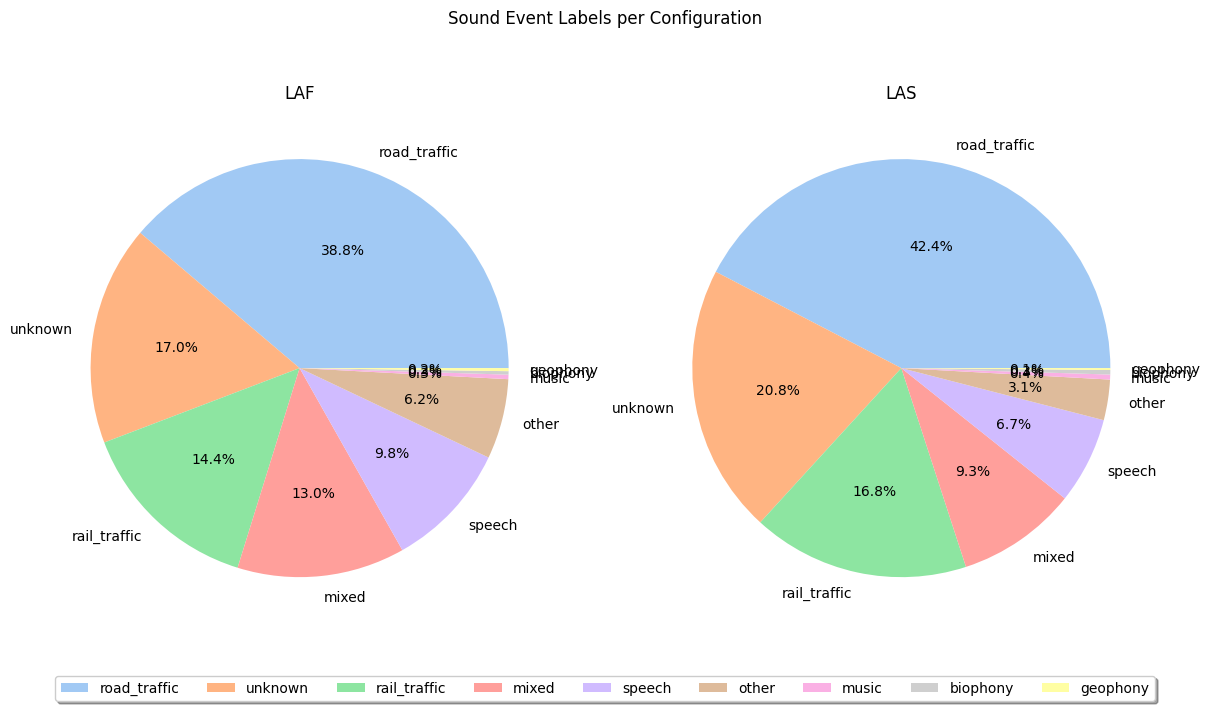

In [19]:
colors = dict(zip(LAS_events.index, sns.color_palette("pastel")[:len(LAS_events.index)]))

fig = plt.figure(figsize=(12,7), constrained_layout=True)
fig.suptitle('Sound Event Labels per Configuration')

# first row, first column
ax1 = plt.subplot2grid((1,2),(0,1))
plt.pie(LAS_events, labels=LAS_events.index, autopct='%1.1f%%', colors=[colors[v] for v in LAS_events.index])
plt.title('LAS')

# first row, second column
ax2 = plt.subplot2grid((1,2),(0,0))
plt.pie(LAF_events, labels=LAF_events.index, autopct='%1.1f%%', colors=[colors[v] for v in LAF_events.index])
plt.title('LAF')

fig.legend(loc='lower center', shadow=True, labels=LAS_events.index, ncol=len(LAS_events.index))
plt.show()

## Of the Sound Events that have been labelled, what is the proportion of "mixed" to "single" sources?

In [20]:
def se_mixed_dist(df):
    df = df.copy()
    df = df['label'].loc[(df['label'] != 'background') & (df['label'] != 'unknown')].value_counts(normalize=True).mul(100)
    try:
        mixed_pct = round(df.loc['mixed'], 2)
    except KeyError:
        mixed_pct = 0.0
    single_pct = round(100-mixed_pct, 2)
    return mixed_pct, single_pct

In [21]:
LAF_mixed, LAF_single = se_mixed_dist(LAF)
LAS_mixed, LAS_single = se_mixed_dist(LAS)

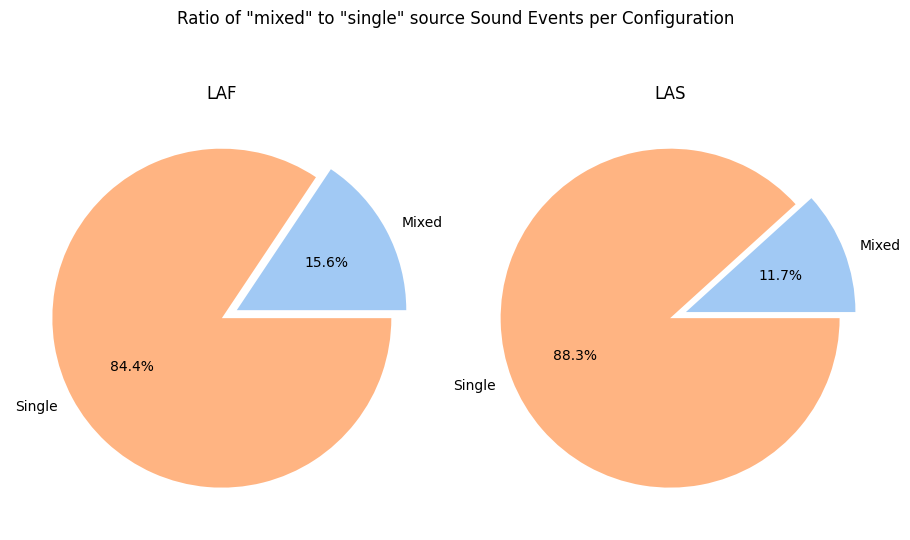

In [22]:
colors = sns.color_palette('pastel')[0:2]

fig = plt.figure(figsize=(9,6), constrained_layout=True)

#1 row 2 columns
fig.suptitle('Ratio of "mixed" to "single" source Sound Events per Configuration')
explode=[0.1, 0]
#first row, first column
ax1 = plt.subplot2grid((1,2),(0,1))
plt.pie([LAS_mixed, LAS_single], labels=['Mixed', 'Single'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAS')

#first row sec column
ax1 = plt.subplot2grid((1,2),(0,0))
plt.pie([LAF_mixed, LAF_single], labels=['Mixed', 'Single'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAF')

plt.show()

## How about at the clip level?

In [23]:
# for each dataset, groupby "clip", then generate se:background distruibutions
def clipwise_mixed_dist(df, speed: str = 'LAF'):
    
    df = df.groupby(['dataset', 'clip'])[['label']].apply(se_mixed_dist)
    df = df.reset_index().drop(columns=['dataset']).set_index('clip')

    df = pandas.DataFrame(df[0].tolist(), index=df.index).reset_index().rename(columns={0: 'mixed'})
    df = df[['clip', 'mixed']]
    df['speed'] = speed
    return df

In [24]:
# summarise at the clip level then concat
ldf = clipwise_mixed_dist(LAF, speed='LAF')
rdf = clipwise_mixed_dist(LAS, speed='LAS')

# concat the df's
df = pandas.concat([ldf, rdf])
df = df.sort_values(by='clip')

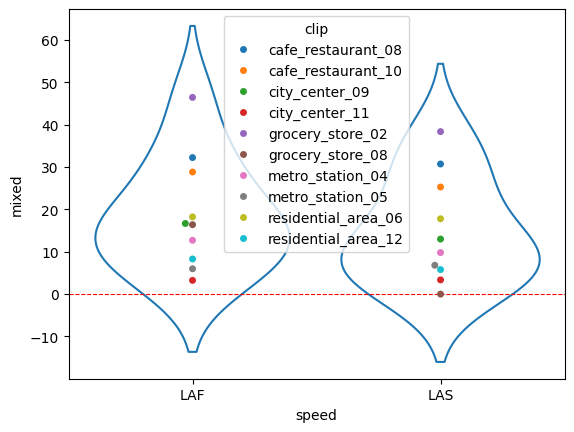

In [25]:
sns.violinplot(data=df, x='speed',  y='mixed', inner=None, fill=False)
sns.swarmplot(data=df, x='speed', y='mixed', hue='clip')
plt.axhline(y=0, color='red', ls='--', linewidth=0.8)

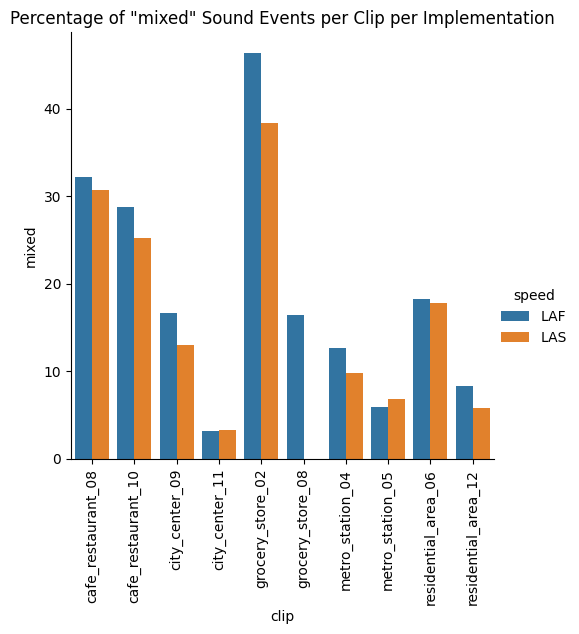

In [26]:
sns.catplot(data=df, x='clip',  y='mixed', hue='speed', kind='bar')
plt.title('Percentage of "mixed" Sound Events per Clip per Implementation')
plt.xticks(rotation=90)
plt.show()

## Why does the "fast" configuration pick up more "mixed" sources?

Fast picks up all the intermittant percusives etc

## For this dataset, what is the proportion of Sound Events that have not been labelled?

In [27]:
# keep "unknown" then roll up the rest of the labels into a "labelled" label

LAF_events = LAF['label'].loc[(LAF['label'] != 'background')].value_counts(normalize=True).mul(100)
LAF_unk = round(LAF_events.loc['unknown'], 2)
LAF_knw = round((100-LAF_unk), 2)

LAS_events = LAS['label'].loc[(LAS['label'] != 'background')].value_counts(normalize=True).mul(100)
LAS_unk = round(LAS_events.loc['unknown'], 2)
LAS_knw = round((100-LAS_unk), 2)
LAS_knw

79.17

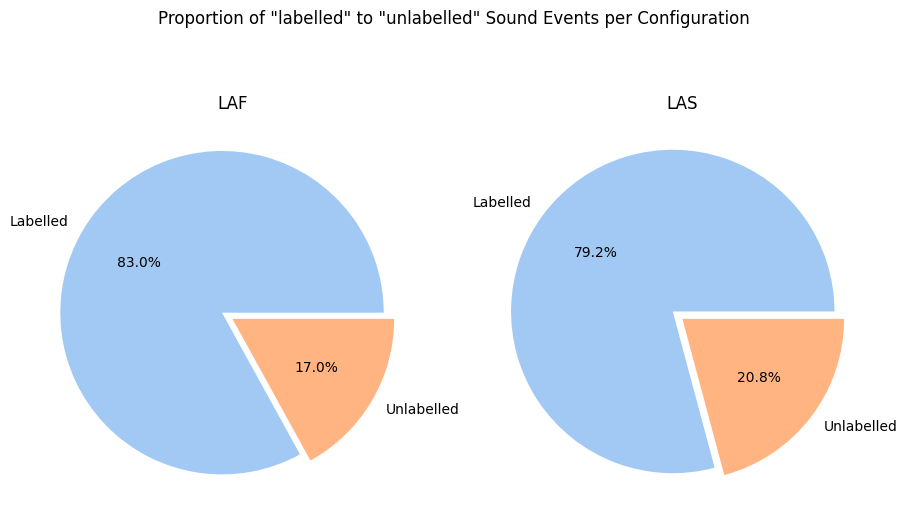

In [28]:
colors = sns.color_palette('pastel')[0:2]
fig = plt.figure(figsize=(9,6), constrained_layout=True)
#1 row 2 columns
fig.suptitle('Proportion of "labelled" to "unlabelled" Sound Events per Configuration')
explode=[0.075, 0]
#first row, first column
ax1 = plt.subplot2grid((1,2),(0,0))
plt.pie([LAF_knw, LAF_unk], labels=['Labelled', 'Unlabelled'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAF')

#first row sec column
ax1 = plt.subplot2grid((1,2),(0,1))
plt.pie([LAS_knw, LAS_unk], labels=['Labelled', 'Unlabelled'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAS')

plt.show()

The differences above could be due to the fact that LAF levels were used to derive the initial Sound Event regions which marked the areas to be annotated.

## How are Sound Events distributed across different clips?

In [29]:
def dense_to_events(df : pandas.DataFrame,
                    category_column='label',
                    time_column='time',
                   ) -> pandas.DataFrame:
    """
    Convert a dense time-series with categories into events with start,end
    """
    df = df.copy() # avoid mutating input
    df['start'] = df[time_column]
    df['end'] = df[time_column]
    changes = df[category_column].ne(df[category_column].shift()).dropna()
    label_groups = changes.cumsum()

    out = df.groupby(label_groups).agg({'start':'min', 'end':'max', category_column:'first'}).reset_index(drop=True)

    return out

In [30]:
from src.visualization.events import plot_events, plot_single_track_labels
from src.data.annotations import class_color_map

def plot(s):
    
    # limit the length of the plot to 10 minutes
    ten_mins = 10 * 60 * 10
    
    if len(s) > ten_mins:
        s = s[:ten_mins]
    
    m = s['label']
    l = s['delta']

    fig, ax = plt.subplots(1, figsize=(15, 2))

    # A) convert back to indicator columns. Use existing multi track plotting
    # will make switches clear - but not obvious that the classes are mutually exclusive
    multi = pandas.get_dummies(m)
    multi = multi.reset_index().set_index('time').drop(columns=['dataset', 'clip'])    
    #plot_multitrack_labels(ax, multi)


    # B) group into runs. Use vspan to plot colored sections
    df = m.to_frame()
    df.columns = ['label']
    df = df.reset_index()
    df['time'] = df.time / pandas.Timedelta(seconds=1) # matplotlib / plot_events() does not like Timedeltas
    df = df.drop(columns=['dataset', 'clip'])

    cons = dense_to_events(df)
    cons['color'] = cons.label.map(class_color_map)
    
    plot_events(ax, cons, color='color', label='label', alpha=1.0)
    
    ndf = l.to_frame()
    clip_name = ndf.index[0][1]
    ndf = ndf.reset_index()
    ndf['time'] = ndf.time / pandas.Timedelta(seconds=1) # matplotlib / plot_events() does not like Timedeltas
    ndf = ndf.drop(columns=['dataset', 'clip'])
    
    sns.lineplot(ax=ax, data=ndf, y='delta', x='time', color='red', alpha=0.8, linewidth=0.7)
    
    ax.axhline(0.0, ls='-', alpha=0.5)
    ax.axhline(5.0, ls='--', alpha=0.5)
    ax.axhline(10.0, ls='--', alpha=0.5)
    
    # plot_single_track_labels(ax, s, colors=class_color_map, alpha=0.5)
    # ax.legend(loc='upper left')
    legend_without_duplicate_labels(ax, loc='lower left')
    
    ax.set_title(clip_name)
    

    

In [31]:
LAF

label      level  \
dataset clip                time                                            
maestro cafe_restaurant_08  0 days 00:00:00         background -62.549446   
                            0 days 00:00:00.100000  background -62.990557   
                            0 days 00:00:00.200000  background -62.900260   
                            0 days 00:00:00.300000  background -62.716761   
                            0 days 00:00:00.400000  background -62.489824   
...                                                        ...        ...   
        residential_area_12 0 days 00:03:19.200000  background -72.229961   
                            0 days 00:03:19.300000  background -72.290979   
                            0 days 00:03:19.400000  background -72.344676   
                            0 days 00:03:19.500000  background -72.613890   
                            0 days 00:03:19.600000  background -72.779996   

                                                    background     delta  
dataset clip                time                                          
maestro cafe_restaurant_08  0 days 00:00:00                NaN       NaN  
                            0 days 00:00:00.100000         NaN       NaN  
                            0 days 00:00:00.200000         NaN       NaN  
                            0 days 00:00:00.300000         NaN       NaN  
                            0 days 00:00:00.400000         NaN       NaN  
...                                                        ...       ...  
        residential_area_12 0 days 00:03:19.200000  -76.458815  4.228854  
                            0 days 00:03:19.300000  -76.458815  4.167836  
                            0 days 00:03:19.400000  -76.458815  4.114138  
                            0 days 00:03:19.500000  -76.458815  3.844924  
                            0 days 00:03:19.600000  -76.458815  3.678818  

[23941 rows x 4 columns]

## Clipwise Activations - LAF

""


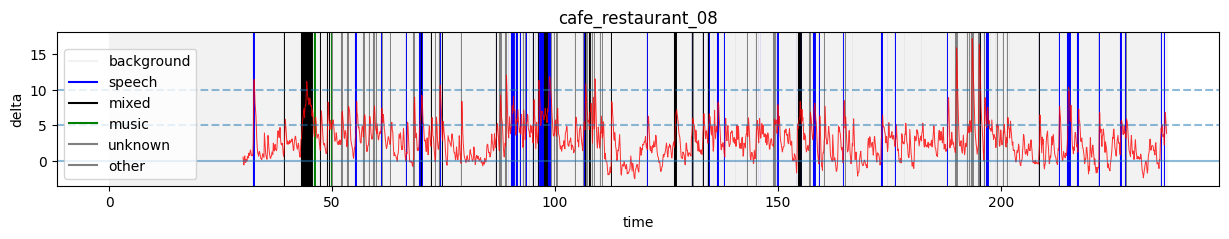

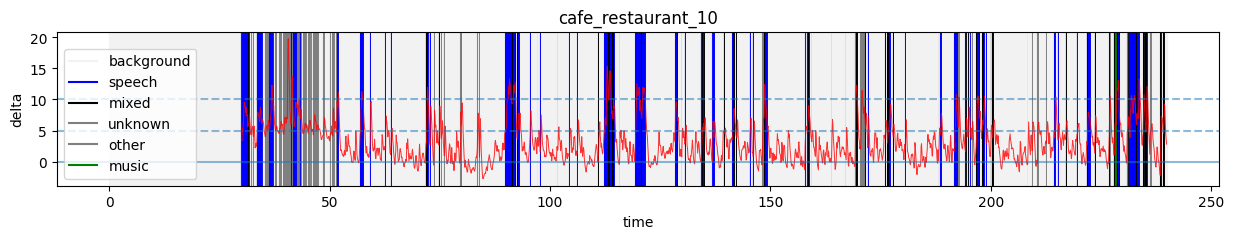

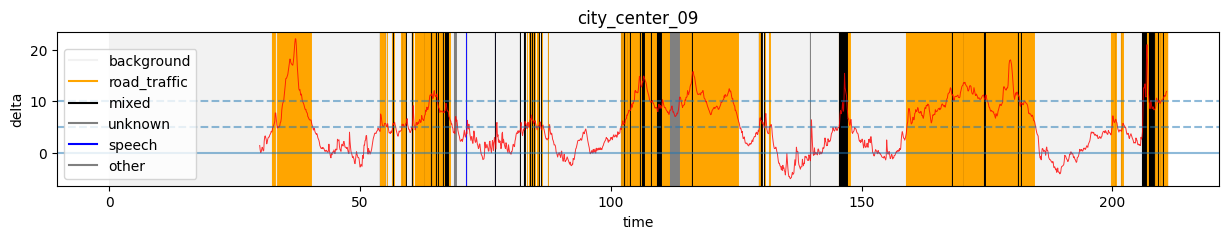

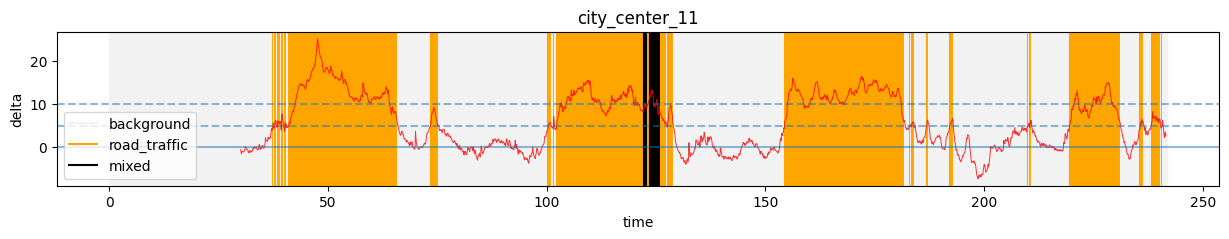

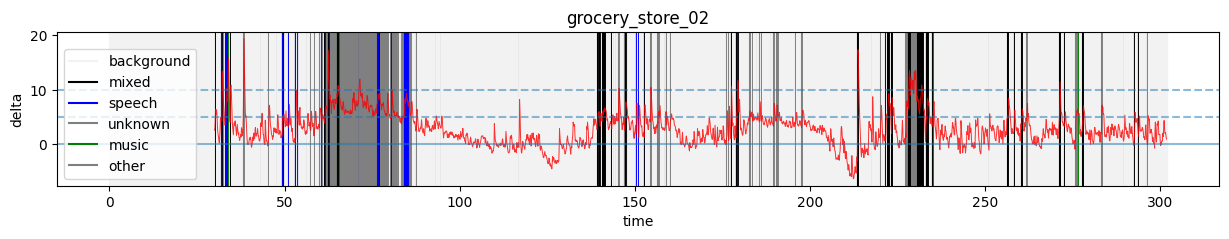

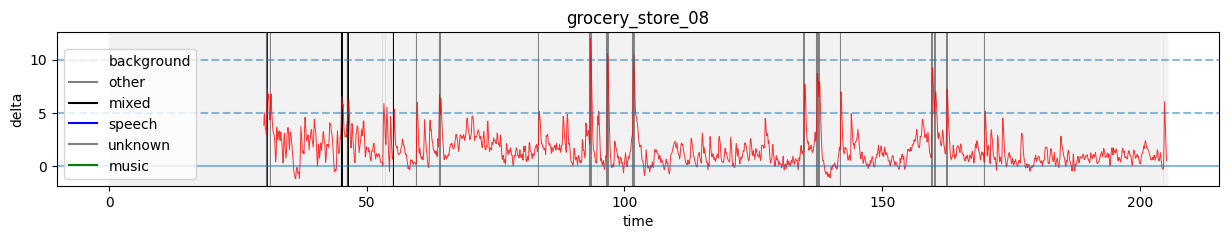

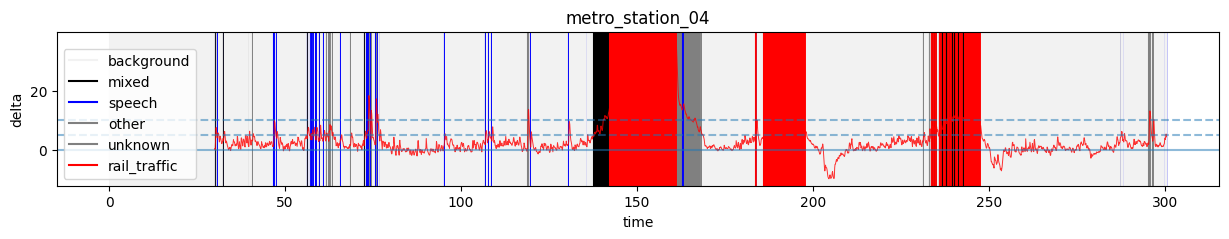

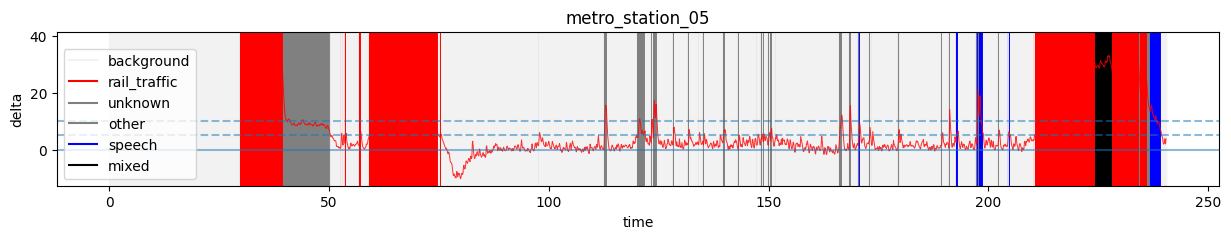

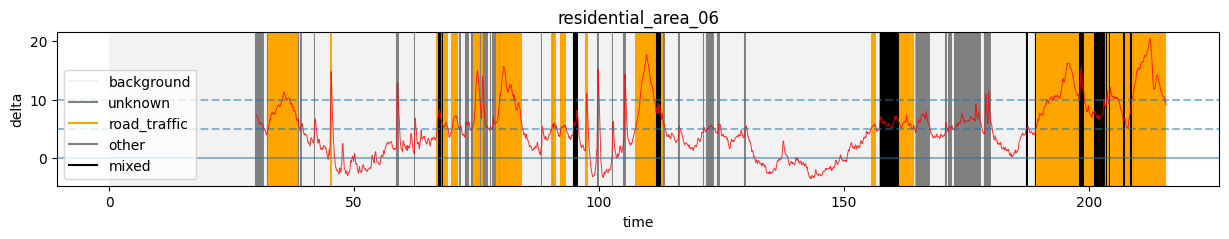

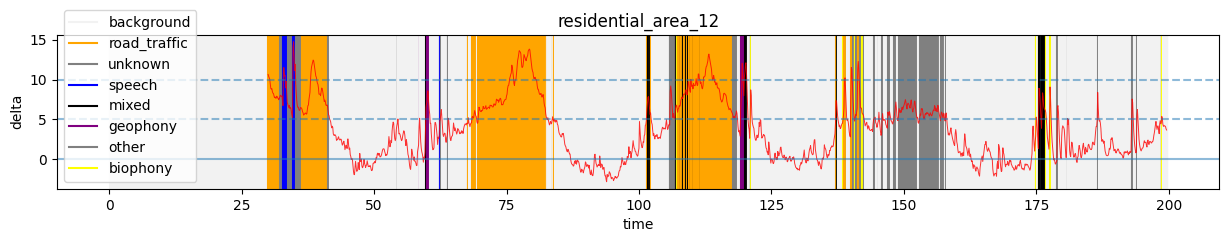

In [34]:
MAESTRO_LAF = LAF.loc[['maestro']]
MAESTRO_LAF.groupby(['dataset', 'clip']).apply(plot)

## Clipwise Activations - LAS

""


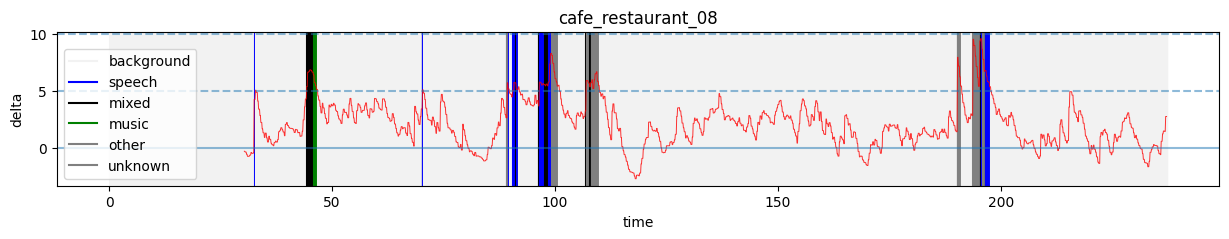

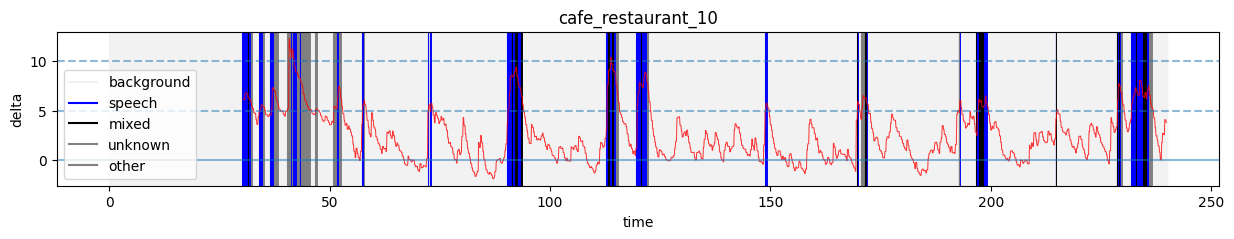

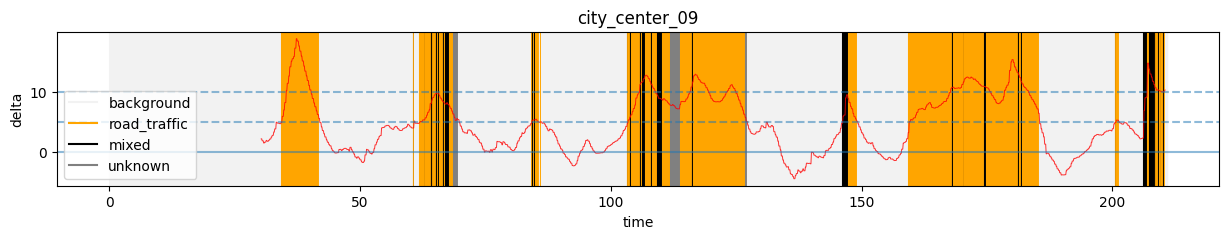

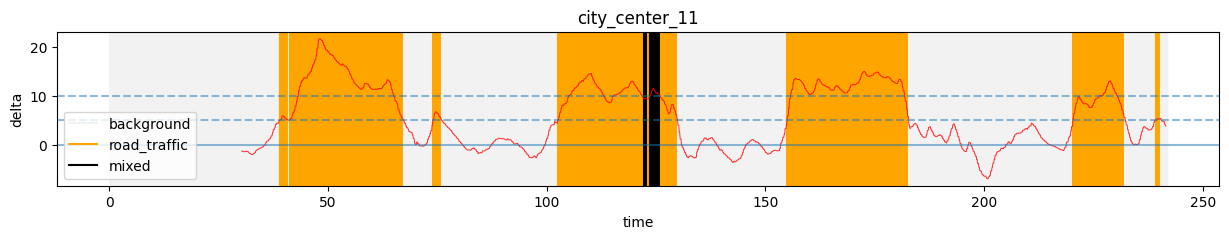

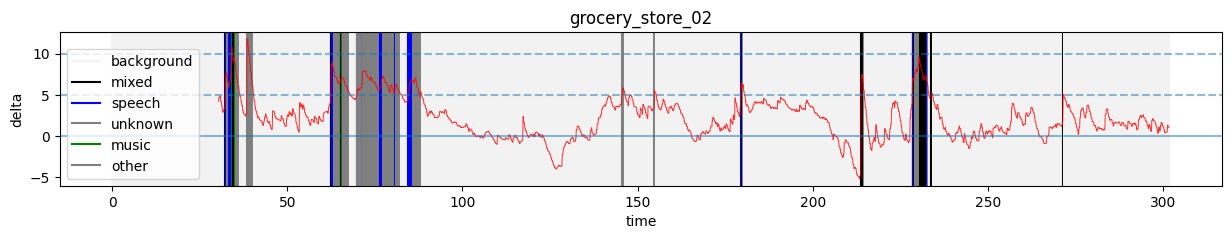

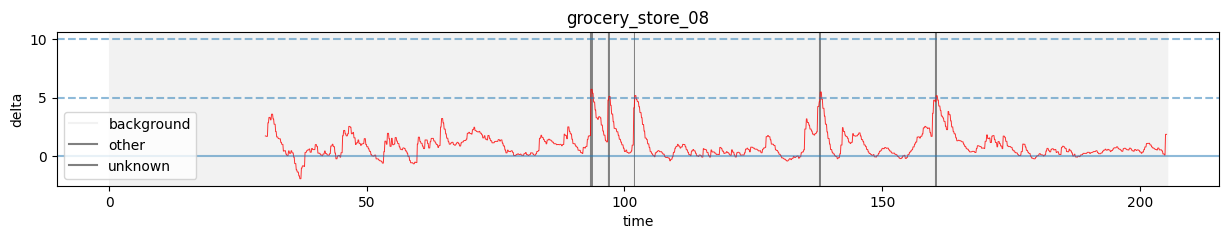

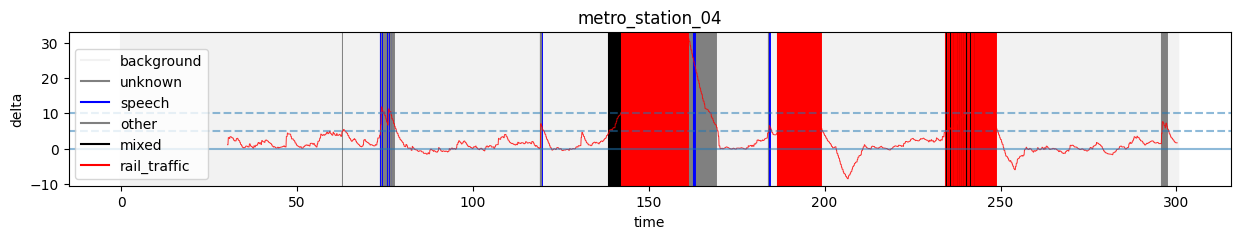

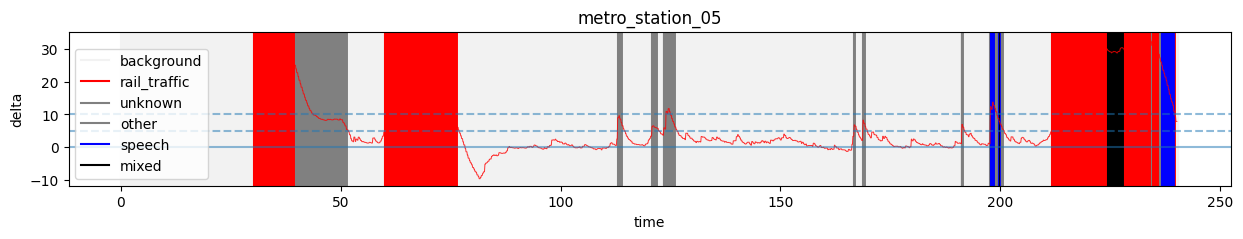

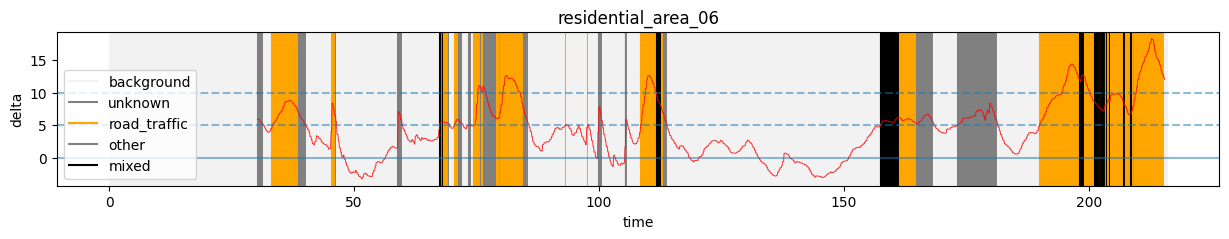

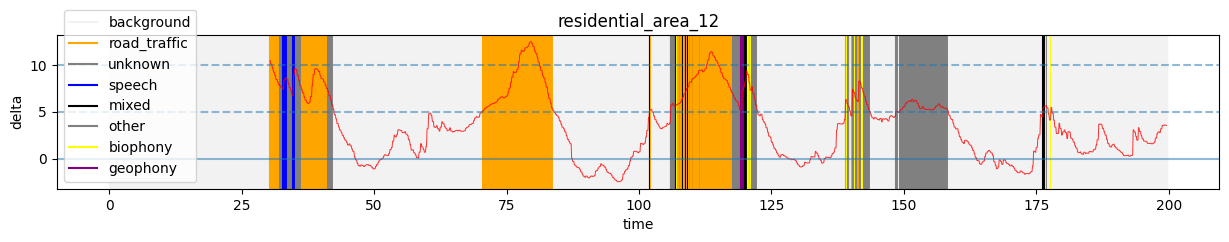

In [35]:
MAESTRO_LAS = LAS.loc[['maestro']]
MAESTRO_LAS.groupby(['dataset', 'clip']).apply(plot)